# 

In [1]:
import numpy as np
import sys,os
sys.path.append(os.getcwd()[:-11]+'src/')
from models import *
from topological_methods import *
import matplotlib.pyplot as plt
clrs = plt.cm.tab20.colors

In [2]:
from torchvision import datasets, transforms

transform=transforms.Compose([transforms.ToTensor()])

data_train = datasets.MNIST('/Users/kosio/Data/MNIST/', train=True, transform=transform, download=True)
data_test = datasets.MNIST('/Users/kosio/Data/MNIST/', train=False, transform=transform,download=True)

trainloader = torch.utils.data.DataLoader(data_train, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(data_test, batch_size=64, shuffle=True)


/Users/kosio/miniconda3/envs/general_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/kosio/miniconda3/envs/general_env/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/kosio/miniconda3/envs/general_env/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <632A2621-54FC-39C2-963C-47795485AE07> /Users/kosio/miniconda3/envs/general_env/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
#output before training
model = FeedforwardNetwork(input_size=data_train.data.shape[1]*data_train.data.shape[2]
                           ,hidden_sizes=[1000,500,250,100], out_layer_sz=10, init_type='normal',
                          mean = 0, std=0.01)
model_pos = FeedforwardNetwork(input_size=data_train.data.shape[1]*data_train.data.shape[2]
                           ,hidden_sizes=[1000,500,250,100], out_layer_sz=10, init_type='normal',
                          mean = 0, std=0.01)
#                          mean = 0, std=1)
net_rank_ratio = 0.5
for layer in model_pos.layers[:-1]:
    if isinstance(layer, nn.Linear):
        R = torch.eye(layer.weight.shape[0])
        rand_inds = np.random.choice(np.arange(0,layer.weight.shape[0]),
                                     size=int(net_rank_ratio*layer.weight.shape[0]), replace=False)
        R[rand_inds,rand_inds] = -1
        layer.weight = torch.nn.Parameter(R@torch.abs(layer.weight))#torch.nn.Parameter(layer.weight+0.0001)#

out = model(data_test.data.reshape(len(data_test.data),-1).float())
out_code = [torch.sum(out[i]>0,axis=1) for i in range(len(out))]

out_pos = model_pos(data_test.data.reshape(len(data_test.data),-1).float())
out_code_pos = [torch.sum(out_pos[i]>0,axis=1) for i in range(len(out_pos))]


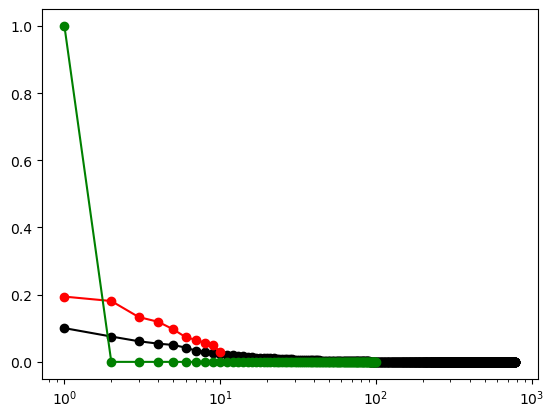

In [4]:
#show the PCA spectrum of the MNIST data
from sklearn.decomposition import PCA
reduced_MNIST = PCA().fit(data_test.data.reshape(len(data_test.data),-1).float())
reduced_output = PCA().fit(out[-1].detach().numpy())
reduced_output_pos = PCA().fit(out_pos[-2].detach().numpy())

plt.plot(np.arange(1,785),reduced_MNIST.explained_variance_ratio_,'k-o')
plt.plot(np.arange(1,len(reduced_output.explained_variance_ratio_)+1),reduced_output.explained_variance_ratio_,'r-o')
plt.plot(np.arange(1,len(reduced_output_pos.explained_variance_ratio_)+1),reduced_output_pos.explained_variance_ratio_,'g-o')
plt.xscale('log')

In [5]:
#Train
import torch.optim as optim
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer_pos = optim.Adam(model_pos.parameters(), lr=0.001)

# Define the training function
def train_model(model, trainloader, criterion, optimizer, num_epochs=20):
    model.train()  # Set the model to training mode
    for epoch in tqdm(range((num_epochs))):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()

            outputs = model(inputs.reshape(len(inputs),-1))[-1]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            #if i % 500 == 99:
            #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 500))
            #    running_loss = 0.0

# Train the model
train_model(model, trainloader, criterion, optimizer)
train_model(model_pos, trainloader, criterion, optimizer_pos)


100%|█████████████████████████████████████████████| 20/20 [01:26<00:00,  4.30s/it]


In [6]:
#output after training
out_post = model(data_test.data.reshape(len(data_test.data),-1).float())
out_code_post = [torch.sum(out_post[i]>0,axis=1) for i in range(len(out_post))]

out_post_pos = model_pos(data_test.data.reshape(len(data_test.data),-1).float())
out_code_post_pos = [torch.sum(out_post_pos[i]>0,axis=1) for i in range(len(out_post_pos))]

In [7]:
print((sum(torch.argmax(out_post[-1],1)==data_test.targets)/len(data_test.targets)).item())
print((sum(torch.argmax(out_post_pos[-1],1)==data_test.targets)/len(data_test.targets)).item())

0.982699990272522
0.9717000126838684


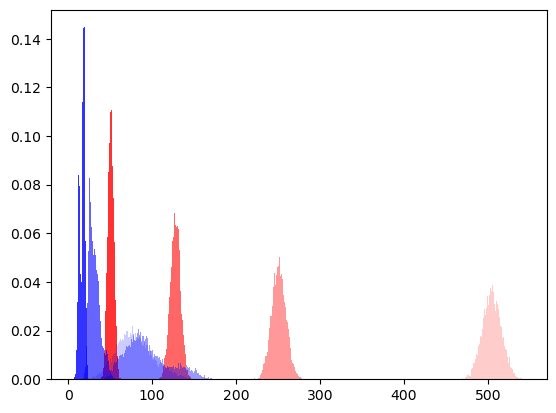

In [8]:
[plt.hist(out_code[i],np.linspace(torch.min(out_code[i]),torch.max(out_code[i]),
                                  torch.max(out_code[i])-torch.min(out_code[i])),
                                  color='red',alpha = i*0.2+0.2,density=True) for i in range(len(out_code)-1)]
_ = [plt.hist(out_code_post[i],np.linspace(torch.min(out_code_post[i]),torch.max(out_code_post[i]),
                                  torch.max(out_code_post[i])-torch.min(out_code_post[i])),
                                  color='blue',alpha = i*0.2+0.2,density=True) for i in range(len(out_code_post)-1)]


In [9]:
np.min(out_code_post[-2].detach().numpy())

6

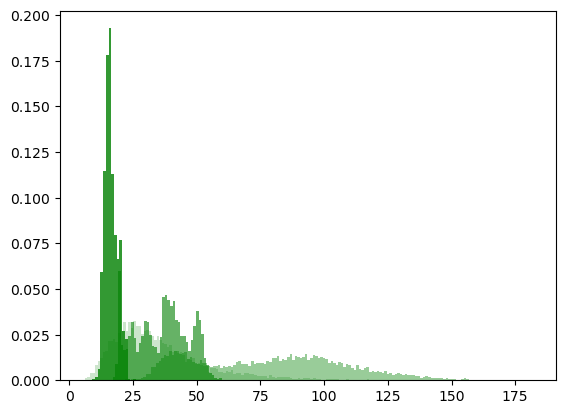

In [10]:
[plt.hist(out_code_pos[i],np.linspace(torch.min(out_code_pos[i]),torch.max(out_code_pos[i]),
                                      torch.max(out_code_pos[i])-torch.min(out_code_pos[i])),
                                      color='purple',alpha = i*0.2+0.4,density=True) for i in range(len(out_code_pos)-1)]
_ = [plt.hist(out_code_post_pos[i],np.linspace(torch.min(out_code_post_pos[i]),torch.max(out_code_post_pos[i]),
                                      torch.max(out_code_post_pos[i])-torch.min(out_code_post_pos[i])),
                                      color='green',alpha = i*0.2+0.2,density=True) for i in range(len(out_code_post_pos)-1)]


In [11]:
#Create phase diagram of performance as a function of weight bias and weight rank
n_repetitions = 10
means = [0,*np.logspace(-2.5,0,14)]
n_models = len(means)
accuracy = np.zeros([n_models,n_repetitions])
ranks = np.zeros([len(models),n_repetitions])

for n in range(n_repetitions):
    for m in range(len(means)):
        mod = FeedforwardNetwork(input_size=data_train.data.shape[1]*data_train.data.shape[2]
                           ,hidden_sizes=[800,400,200,100], out_layer_sz=10, init_type='normal',
                          mean = means[m], std=0.01)
        optimizer = optim.Adam(mod.parameters(), lr=0.001)
        train_model(mod, trainloader, criterion, optimizer)
        model_out = mod(data_test.data.reshape(len(data_test.data),-1).float())
        accuracy[m,n] = (sum(torch.argmax(model_out[-1],1)==data_test.targets)/len(data_test.targets)).item()
        ranks[m,n] = min([min(torch.sum(model_out[i]>0,axis=1)).item() for i in range(len(model_out)-1)])

NameError: name 'models' is not defined

In [ ]:
plt.plot(np.array(means)+1e-3, np.mean(accuracy,1),'-o')
plt.xscale('log')